In [1]:
# general imports
import pandas as pd
import numpy as np
from collections import Counter
import json

In [2]:
# text processing
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
# unsupervised learning
from sklearn.cluster import KMeans
from gensim.models import KeyedVectors

In [4]:
# multiclass classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [5]:
#visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from IPython.display import HTML, display

In [6]:
data_directory = './pickles/dataframes'

# 1) Loading data

Load all the data dataframes from json, they are raw uncleaned scrapped websites

In [7]:
all_recipe_df = pd.read_json(data_directory + '/all_recipe_df_raw.json')

In [8]:
food_com_df  = pd.read_json(data_directory + '/food_com_df_raw.json')

In [9]:
food_net_df  = pd.read_json(data_directory + '/food_net_df_raw.json')

__NOTE__ : We will first clean each dataframe alone as each one of them contains different features.

# 2) Cleaning  all_recipe.com 

In [10]:
all_recipe_df.head() # get glimpse of the data

,calories,cholesterol,cook_time,dietaryfiber,fat,ingredients,name,prep_time,protein,rating,review,review_date,servings,sodium,total_time,totalcarbs
0,298,76mg,45M,1g,22.9g,"[1 (16 ounce) jar sauerkraut, drained, 1 (8 ou...",Slow Cooker Reuben Dip,4M,17.9g,4,I am always looking for great crockpot recipes...,"Dec. 6, 2005",12,636mg,49M,5.5g
1,298,76mg,45M,1g,22.9g,"[1 (16 ounce) jar sauerkraut, drained, 1 (8 ou...",Slow Cooker Reuben Dip,4M,17.9g,4,Enjoyed this recipe! I chopped the sauerkraut...,"Feb. 17, 2008",12,636mg,49M,5.5g
10,167,< 1mg,10M,0.8g,6.9g,"[1 (.25 ounce) package active dry yeast, 1/4 c...",Angel Biscuits II,35M,3.5g,4,Preheat oven to 200 degrees. When oven reaches...,"Jan. 5, 2008",24,329mg,1H45M,22.7g
100,64,13mg,15M,0.3g,5.4g,"[1 tablespoon olive oil, 16 spears fresh aspar...",Asparagus Wrapped in Crisp Prosciutto,5M,3.1g,4,This was the first proscuitto and asparagus re...,"Jun. 7, 2006",16,279mg,20M,0.6g
1000,354,53mg,15M,3.4g,19.8g,"[1 bunch fresh asparagus, trimmed and cut into...",Fried Asparagus,10M,7.4g,3,I only tried it with a couple of stalks just i...,"Apr. 21, 2007",4,533mg,25M,37.5g


In [11]:
print("Number of recipes extracted = {}".format(all_recipe_df['name'].unique().shape[0]))

Number of recipes extracted = 9109


In [12]:
all_recipe_df.dtypes # get the data types of the columns in the data

calories         int64
cholesterol     object
cook_time       object
dietaryfiber    object
fat             object
ingredients     object
name            object
prep_time       object
protein         object
rating           int64
review          object
review_date     object
servings         int64
sodium          object
total_time      object
totalcarbs      object
dtype: object

## 2.a) Processing nutirition facts

The first step of cleaning is to convert nutrition information having different scales into one scale. <br>
These include the columns:
1. cholesterol    
2. dietaryfiber
3. fat
4. protein
5. sodium
6. totalcarbs

In [13]:
# keep nondigit letters in ingredient columns to see what needs to be cleaned
cholesterol_scale = all_recipe_df['cholesterol'].str.replace('\d+','').unique()
dietary_scale     = all_recipe_df['dietaryfiber'].str.replace('\d+','').unique()
fat_scale         = all_recipe_df['fat'].str.replace('\d+','').unique()
protein_scale     = all_recipe_df['protein'].str.replace('\d+','').unique()
sodium_scale      = all_recipe_df['sodium'].str.replace('\d+','').unique()
carbs_scale       = all_recipe_df['totalcarbs'].str.replace('\d+','').unique()

In [14]:
scales_dict = {
    'cholesterol' : ' , '.join(cholesterol_scale),
    'dietary'     : ' , '.join(dietary_scale),
    'fat'         : ' , '.join(fat_scale),
    'protein'     : ' , '.join(protein_scale),
    'sodium'      : ' , '.join(sodium_scale),
    'carbs'       : ' , '.join(carbs_scale)
}

In [15]:
def render_dict_html(d):
    o = []
    for k, v in d.items():
        o.append('<tr><td>%s</td><td>%s</td></tr>' % (str(k), render_as_html(v)))
    return '<table>%s</table>' % ''.join(o)

def render_as_html(e):
    o = []
    if isinstance(e, list):
        o.append(render_list_html(e))
    elif isinstance(e, dict):
        o.append(render_dict_html(e))
    else:
        o.append(str(e))
    return '<html><body>%s</body></html>' % ''.join(o)

In [16]:
display(HTML(render_as_html(scales_dict)))

carbs,".g , g"
sodium,"mg , < mg"
fat,".g , g"
dietary,"g , .g"
cholesterol,"mg , < mg"
protein,".g , g"


From the table above all scales are the same per column and thus we just need to remove these strings from the columns and convert to integer.

In [17]:
# remove everything keep only digits
all_recipe_df['cholesterol']  = all_recipe_df['cholesterol'].str.extract('(\d+)').astype(int)
all_recipe_df['dietaryfiber'] = all_recipe_df['dietaryfiber'].str.extract('(\d+)').astype(int)
all_recipe_df['fat']          = all_recipe_df['fat'].str.extract('(\d+)').astype(int)
all_recipe_df['protein']      = all_recipe_df['protein'].str.extract('(\d+)').astype(int)
all_recipe_df['sodium']       = all_recipe_df['sodium'].str.extract('(\d+)').astype(int)
all_recipe_df['totalcarbs']   = all_recipe_df['totalcarbs'].str.extract('(\d+)').astype(int)

In [20]:
all_recipe_df['cholesterol'],all_recipe_df['sodium'] = all_recipe_df['cholesterol']/1000.0,all_recipe_df['sodium']/1000.0

In [22]:
all_recipe_df[['cholesterol','dietaryfiber','fat','protein','sodium','totalcarbs']].dtypes # to verify the data types and check that they are numeric

cholesterol     float64
dietaryfiber      int64
fat               int64
protein           int64
sodium          float64
totalcarbs        int64
dtype: object

## 2.b) Clean time based columns

The next step is to clean the time and date columns and extract usefull information from them. <br>
These columns include:
1. prep_time   : total time to prepare the ingredients of the recipe to be cooked
2. cook_time   : total time to be spent to cook the meal
3. total_time  : total time to cook a recipe
4. review_date : the date which the review of the recipe is given

In [23]:
all_recipe_df['prep_time'].str.replace('\d+','').unique()

array([u'M', u'H', nan, u'DayH', u'HM', u'Day', u'DaysH', u'DaysHM'],
      dtype=object)

In [24]:
all_recipe_df['cook_time'].str.replace('\d+','').unique()

array([u'M', u'HM', u'H', nan, u'Day', u'DayH', u'DaysH'], dtype=object)

In [25]:
all_recipe_df['total_time'].str.replace('\d+','').unique()

array([u'M', u'HM', u'H', nan, u'DayH', u'Days', u'DaysHM', u'DayM',
       u'Day', u'DayHM', u'DaysM', u'DaysH'], dtype=object)

We can see from the above that all these 3 columns have different scales. The next step is to rescale all of them down to minute scale as it is the smallest among them. <br>
A small explanation of the scales:
1. M    : kept the same value
2. H    : each value is multiplied by 60
3. Day/Days  : each value is multiplied by 3600
<br>

You can see that these values in the presented scales are appended to each other since they are seperated by the digits. For the nan value no scale was presented.

In [26]:
scale = ['Day','H','M']

In [27]:
def rescale_time(meal_time,scale):
    
    if isinstance(meal_time,int):
        return meal_time
    else:
    
        if 's' in meal_time:
            meal_time = meal_time.replace('s','')

        total_time = 0
        for i in range(0,len(scale)):
            
            res = meal_time.split(scale[i])
            if res[0] == meal_time:
                continue
            else:
                meal_time = res[1]
                if scale[i] == 'Day':
                    cnst = 3600
                elif scale[i] == 'H':
                    cnst = 60
                elif scale[i] == 'M':
                    cnst = 1

                total_time += (int(res[0]) * cnst)


        return total_time
    

In [28]:
# convert all sclaes
all_recipe_df['prep_time']  = all_recipe_df['prep_time'].apply(lambda x : rescale_time(x,scale))
all_recipe_df['cook_time']  = all_recipe_df['cook_time'].apply(lambda x : rescale_time(x,scale))
all_recipe_df['total_time'] = all_recipe_df['total_time'].apply(lambda x : rescale_time(x,scale))

Now for month data we just need to extract three features days,month and year. We perform this by adding these columns by extracting the needed info.

In [29]:
month_mapping = dict({'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12})

In [30]:
def extract_month(date,month_scale):
    dates_split = date.replace(',','').replace('.','').split(' ')
    return month_scale[dates_split[0]]

In [31]:
def extract_day(date):
    dates_split = date.replace(',','').replace('.','').split(' ')
    return dates_split[1]

In [32]:
def extract_year(date):
    dates_split = date.replace(',','').replace('.','').split(' ')
    return dates_split[2]

In [33]:
# extract all date features
all_recipe_df['day'] = all_recipe_df['review_date'].apply(lambda x : extract_day(x)).astype(int)
all_recipe_df['month'] = all_recipe_df['review_date'].apply(lambda x : extract_month(x,month_mapping)).astype(int)
all_recipe_df['year'] = all_recipe_df['review_date'].apply(lambda x : extract_year(x)).astype(int)
all_recipe_df = all_recipe_df.drop('review_date',axis=1)

In [34]:
all_recipe_df[['day','month','year','prep_time','cook_time','total_time']].dtypes # verify results

day           int64
month         int64
year          int64
prep_time     int64
cook_time     int64
total_time    int64
dtype: object

## 2.c) Bucketing Ratings

We can do two options with the ratings:
1. Keep them as is
2. Bucketing

In [35]:
all_recipe_df_ratings = all_recipe_df['rating'].values

In [36]:
rating_distribution = dict(Counter(all_recipe_df_ratings))

<BarContainer object of 5 artists>

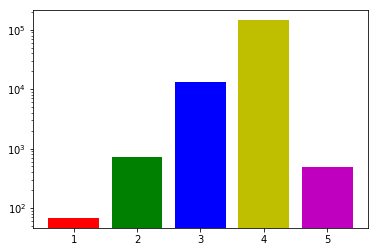

In [37]:
plt.bar(rating_distribution.keys(),rating_distribution.values(),color='rgbym',log=True)

In [38]:
review_buckets = {1:0,2:0,3:1,4:2,5:2}
bucketized_data = map(lambda x : review_buckets[x],all_recipe_df_ratings.tolist())

In [39]:
bucket_distribution = dict(Counter(bucketized_data))

<BarContainer object of 3 artists>

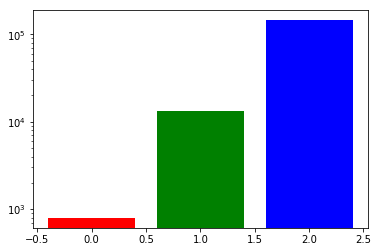

In [40]:
plt.bar(bucket_distribution.keys(),bucket_distribution.values(),color='rgbym',log=True)

Thus we prefer to keep the ratings as is so that they are more granular.

## 2.d) Cleaning ingredient information

The aim from this part is to cluster the ingredients into categories, such as : meats,cheese,dough ...
Thus extract for each recipe features having the counts of these clusters.

We will start with cleaning the ingredient text. Each row in the dataframe consists a review for a certain recipe and thus many rows may correspond to the same recipe, thus we filter the rows to keep the unique recipes.

In [96]:
# construct a dataframe having all rows groupped by the recipe name
# this dataframe compress the rows and keeps for each recipe the ingredients
all_recipe_unique_recipes = all_recipe_df.groupby('name')['ingredients'].apply(list)

In [97]:
for i in range(0,len(all_recipe_unique_recipes)):
    all_recipe_unique_recipes[i] = all_recipe_unique_recipes[i][0]

In [98]:
all_recipe_unique_recipes[0]

[u'2 1/2 cups all-purpose flour',
 u'1 cup rolled oats',
 u'4 teaspoons baking powder',
 u'1 1/2 teaspoons ground cinnamon',
 u'1/2 teaspoon ground nutmeg',
 u'1 teaspoon pumpkin pie spice',
 u'1/2 teaspoon ground ginger',
 u'1/4 teaspoon salt',
 u'2 tablespoons butter',
 u'1 1/3 cups light brown sugar',
 u'2 eggs',
 u'1 teaspoon vanilla extract',
 u'1 (15 ounce) can pumpkin',
 u'1/2 cup apple butter',
 u'1 cup chopped walnuts']

Now we need to start cleaning the ingredients. We need to remove the measurments (numbers). Then tokenize and try to remove as much as possible non-food related words.

In [99]:
def remove_noncharacters(input_):
    return re.sub('[^a-zA-Z]','',input_) # remove all non-alphabetic characters

In [100]:
def remove_brackets_content(input_):
    return re.sub(r'\([^)]*\)', '',input_) # remove all contents inside brackets

In [101]:
def tokenize(input_):
    return input_.split() # tokenize all words by splitting by space (string => list)

In [102]:
def remove_stop_words(stop_words,input_):
    return list(filter(lambda x : x not in stop_words,input_)) # remove stopwords

In [103]:
def remove_nonrelevant_pos_tags(tagged_elements):
    # keep all tags that are nous otherwise remove them
    pos_tag_check = lambda x: (x[1].startswith("VB")) or (x[1].startswith("JJ")) or (x[1].startswith("RB"))
    return list(filter(lambda tagged_word : not pos_tag_check(tagged_word),tagged_elements))

In [104]:
def cleaning_ingredients(ingreds):
    
    cleaned_corpus = []
    stop = stopwords.words('english')
    lem = WordNetLemmatizer()
    for i in range(0,len(ingreds)):

        cnst_a = list(map(lambda x : remove_brackets_content(x),ingreds[i])) # remove all text inside brackets
        cnst_b = list(map(lambda x : tokenize(x),cnst_a)) # tokenize all ingredient elements
         # remove all non alphabets
        cnst_c = list(map(lambda x : map(lambda y:remove_noncharacters(y),x) ,cnst_b))
        cnst_c = list(map(lambda x : filter(lambda y : y!='',x),cnst_c))
        cnst_d = list(map(lambda x : map(lambda y : y.lower(),x),cnst_c)) # change to lower case
        cnst_e = list(map(lambda x : remove_stop_words(stop,x),cnst_d)) # remove stopwords
        cnst_f = list(map(lambda x : nltk.pos_tag(x),cnst_e)) # tag words
        cnst_g = list(map(lambda x : remove_nonrelevant_pos_tags(x),cnst_f)) # remove elements having non-needed pos tags
        cnst_h = list(map(lambda x : map(lambda y : y[0],x) ,cnst_g)) # keep tokens and remove pos tags
        cnst_i = map(lambda x : map(lambda y : lem.lemmatize(y),x) ,cnst_h) # leammatize
        cleaned_corpus.append(cnst_i)
    
    return cleaned_corpus
    

In [105]:
def get_ingredients(cleaned_recipes):
    # a function to flatten the recipes
    flattened = []
    for i in range(0,len(cleaned_recipes)):
        for j in range(0,len(cleaned_recipes[i])):
            for k in range(0,len(cleaned_recipes[i][j])):
                flattened.append(cleaned_recipes[i][j][k])
    return flattened

In [106]:
def plot_frequency(corpus):
    
    counts = Counter(corpus)

    labels, values = zip(*counts.items())

    # sort your values in descending order
    indSort = np.argsort(values)[::-1]

    # rearrange your data
    labels = np.array(labels)[indSort]
    values = np.array(values)[indSort]

    temp1 = values[0:20]
    temp2 = labels[0:20]
    
    indexes = np.arange(len(temp2))

    bar_width = 0.35
    plt.rcParams["figure.figsize"] = (20,5)
    plt.bar(indexes, temp1)

    # add labels
    plt.xticks(indexes + bar_width, labels)
    plt.show()

In [107]:
# list having the ingredients cleaned by applying the text cleaning procedure
all_recipe_cleaned_ingreds = cleaning_ingredients(all_recipe_unique_recipes) 

In [108]:
all_recipe_flattened = get_ingredients(all_recipe_cleaned_ingreds)

In [109]:
# apply cleaning also on series having unique recipes
all_recipe_unique_recipes = all_recipe_unique_recipes.apply(lambda x: cleaning_ingredients([x]) )

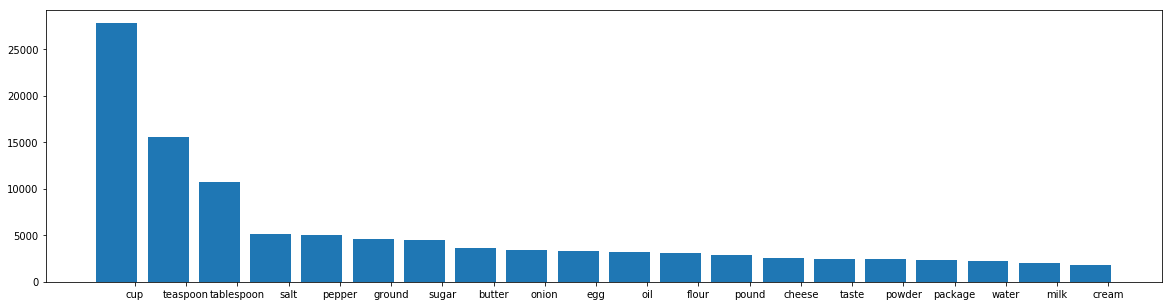

In [111]:
plot_frequency(all_recipe_flattened)

Some common words in the culinary world include measumrent, such as : cup,teaspoon and tablespoon. We omit these from the analysis.

In [112]:
measurments = ['cup','teaspoon','tablespoon','pinch','pound','ounce','taste','cups','tablespoons','teaspoons']
all_recipe_flattened = list(filter(lambda x: x not in measurments,all_recipe_flattened))
all_recipe_cleaned_ingreds = map(lambda x: map(lambda y : [z for z in y if z not in measurments],x),all_recipe_cleaned_ingreds)

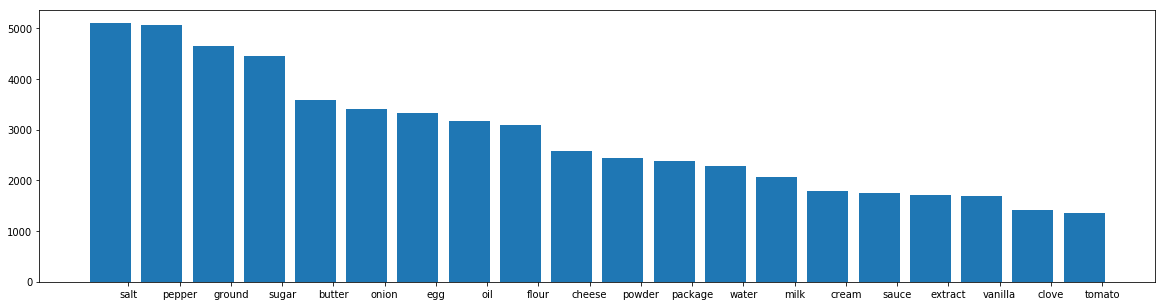

In [113]:
plot_frequency(all_recipe_flattened)

After applying the cleaning, we want to cluster the words we have into main food categories. We will use pretrained word2vec vectors. These are downloaded from : <a href="https://github.com/alexandres/lexvec#pre-trained-vectors">here</a>

In [69]:
word2vec_model = KeyedVectors.load_word2vec_format('./embeddings/lexvec.commoncrawl.ngramsubwords.300d.W.pos.vectors', binary=False)

The first attempt is to visualize the word vectors in 2d. Thus we compute the vectors of word2vec of the ingredients in the dataset then project them in to two dimensions using tsne. Maybe we can find some clusters

In [114]:
def get_tsne_projections(model,ingreds):
    
    labels = []
    tokens = []

    for word in ingreds:
        try:
            tokens.append(model[word])
            labels.append(word)
        except:
            continue

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    return x,y,tokens,labels

In [115]:
def tsne_plot(x,y,labels):
         
    plt.figure(figsize=(15, 15)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [116]:
all_recipe_x,all_recipe_y,all_recipe_vectors,all_recipe_labels = get_tsne_projections(word2vec_model,np.unique(all_recipe_flattened))

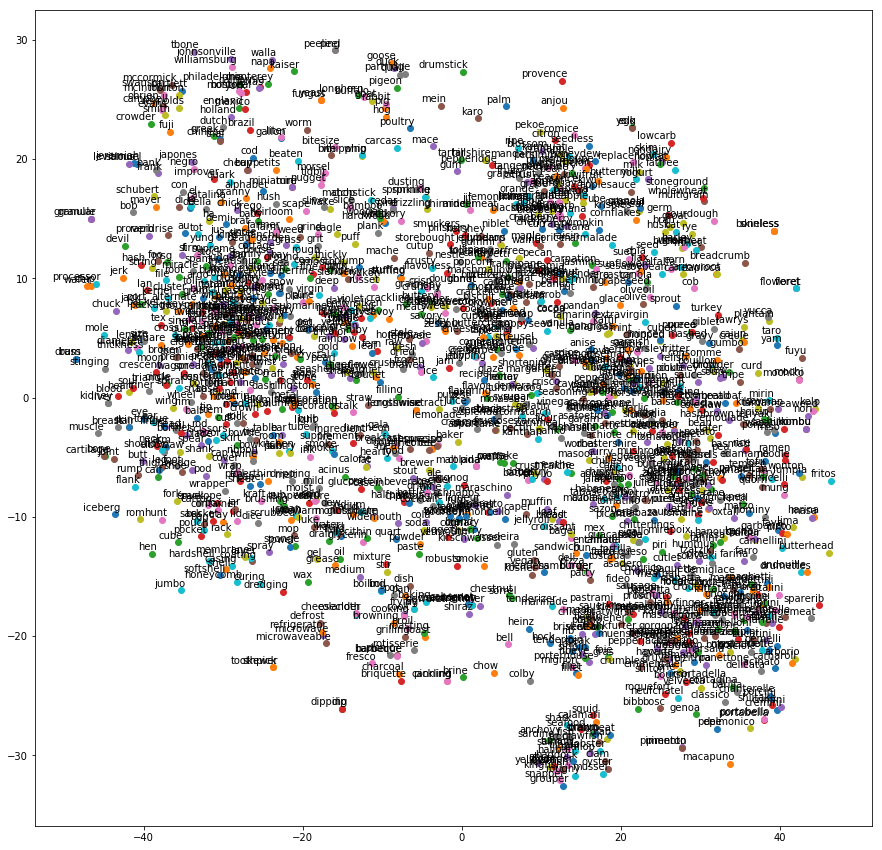

In [117]:
tsne_plot(all_recipe_x,all_recipe_y,all_recipe_labels)

As observed from the plot above, it is really hard to detect any clusters, we will use kmeans to cluster these embeddings.

In [118]:
# create the matrix to apply clustering on
all_recipe_vectors,all_recipe_labels = np.asarray(all_recipe_vectors),np.asarray(all_recipe_labels)
all_recipe_labels = all_recipe_labels.reshape(-1,1)
temp = np.hstack((all_recipe_vectors,all_recipe_labels))
all_recipe_vectors_df = pd.DataFrame(temp)

In [119]:
all_recipe_vectors_df = all_recipe_vectors_df.rename(columns={300:'ingreds'})

In [120]:
all_recipe_vectors_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,ingreds
0,-0.115917,-0.039895,-0.197839,0.076672,-0.016137,-0.120831,-0.102137,-0.022113,0.236932,-0.124784,...,0.175291,-0.304935,0.033267,-0.014657,0.086908,-0.092054,-0.004493,-0.042423,0.097751,achiote
1,0.167603,-0.054722,0.077679,-0.11937,0.069324,0.032744,0.247632,-0.036924,-0.132696,-0.052732,...,0.024036,0.121796,0.036537,0.029609,-0.052977,-0.099181,-0.072846,-0.008836,-0.049126,acid
2,0.243377,0.297705,0.113111,0.12885,-0.253405,-0.212215,-0.081373,-0.306011,-0.050842,-0.101237,...,0.18257,-0.036555,-0.097559,-0.150042,0.163546,0.075541,0.076129,-0.025974,-0.031822,acinus
3,0.037905,-0.095917,-0.104802,0.009615,0.072668,-0.230151,0.069384,0.020203,0.028175,-0.180208,...,-0.159758,0.015869,-0.013746,-0.027939,0.281874,0.102379,0.0615,-0.077196,-0.022463,adobo
4,0.033443,0.051869,0.118463,0.054114,-0.060714,-0.232838,-0.034893,0.005562,0.165613,-0.036502,...,0.091539,0.03119,-0.111768,0.098885,0.030854,-0.049104,-0.079241,-0.054921,0.134822,ahi


To use kmeans, we will implement the function to select k by computing the silhouette of each datapoint and find the k with the maximum s. Then cluster them according to that s.

In [121]:
def compute_centroid_distances(centroids):
    distances = {}
    for i in range(0,len(centroids)):
        distances[i] = {}
    for key in distances:
        for key2 in distances:
            if key!=key2:
                dist = np.linalg.norm(centroids[key] - centroids[key2])
                distances[key][dist] = key2
    return distances

In [122]:
def kmeans_plus(vectors):
    
    data = vectors.values
    data = data.astype('float')
    
    s_of_k = {}
    
    for k in range(2,35):

        kmeans_algorithm = KMeans(n_clusters=k,random_state=0).fit(data)
        data_labels = kmeans_algorithm.labels_
        centroids = kmeans_algorithm.cluster_centers_
        distances = compute_centroid_distances(centroids)
        
        S = []
        
        for i in range(data.shape[0]):
            point_label = data_labels[i]
            nearest_neighbour_id = distances[point_label][min(distances[point_label].keys())]
            
            
            distance_to_own_centroid     = np.linalg.norm(data[i,:] - centroids[point_label])
            distance_to_nearest_centroid = np.linalg.norm(data[i,:] - centroids[nearest_neighbour_id])
            max_of_two = max(distance_to_own_centroid,distance_to_nearest_centroid)
            
            silhouette = (distance_to_nearest_centroid - distance_to_own_centroid)/(max_of_two + 1e-12)
            S.append(silhouette)
        
        s_of_k[k] = np.mean(S)
        
        
    return s_of_k

In [123]:
temp_benchmark = all_recipe_vectors_df.loc[:, ~all_recipe_vectors_df.columns.isin(['ingreds'])]
sil_vs_k = kmeans_plus(temp_benchmark)

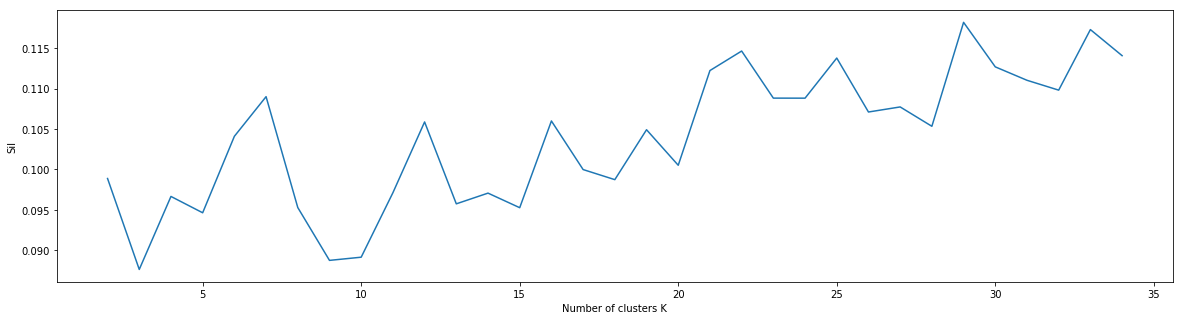

In [124]:
plt.xlabel('Number of clusters K')
plt.ylabel('Sil')
plt.plot(sil_vs_k.keys(),sil_vs_k.values())

We can see that a k of 29 achieves best performance

In [125]:
kmeans_algorithm = KMeans(n_clusters=29,random_state=0).fit(temp_benchmark.values)

In [126]:
all_recipe_vectors_df['labels'] = kmeans_algorithm.labels_

In [127]:
# create a dataframe having 5 samples of each label
sampled_data = []
for i in range(0,29):
    subset = all_recipe_vectors_df[all_recipe_vectors_df['labels'] == i]
    subset = subset.sample(5)
    sampled_data.append(subset)
sampled_data = pd.concat(sampled_data)

In [128]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(sampled_data[['ingreds','labels']])

,ingreds,labels
134,brisket,0
1375,wiener,0
692,lamb,0
225,chicken,0
1340,venison,0
1036,replacer,1
1168,soda,1
1237,sugar,1
821,monosodium,1
633,improver,1


Now after sampling , we use our knowledge to label the clusters. We use the majority of elements to label a certain clsuter.

In [129]:
cluster_labeling = {0:'Meat and Chicken',
                    1:'Chemical Components',
                    2:'Irrelevant',
                    3:'Cheese and Bread',
                    4:'Irrelevant',
                    5:'Drinks',
                    6:'Pasta',
                    7:'Units',
                    8:'Irrelevant',
                    9:'Herbes',
                    10:'Sushi',
                    11:'Sauces',
                    12:'Irrelevant',
                    13:'Pastry',
                    14:'Starch',
                    15:'Irrelevant',
                    16:'Spices',
                    17:'Irrelevant',
                    18:'Vegtables',
                    19:'Drinks',
                    20:'Irrelevant',
                    21:'Dipping',
                    22:'Beans and Rice',
                    23:'Irrelevant',
                    24:'Irrelevant',
                    25:'Fruits',
                    26:'Fish',
                    27:'Irrelevant',
                    28:'Irrelevant'
                   }

In [130]:
def plot_centroids(centroids,clusters):
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(centroids)

    x = []
    y = []
    labels = []
    for i in range(0,len(new_values)):
        if clusters[i] != 'Irrelevant':
            labels.append(clusters[i])
            x.append(new_values[i][0])
            y.append(new_values[i][1])
    
    tsne_plot(x,y,labels)

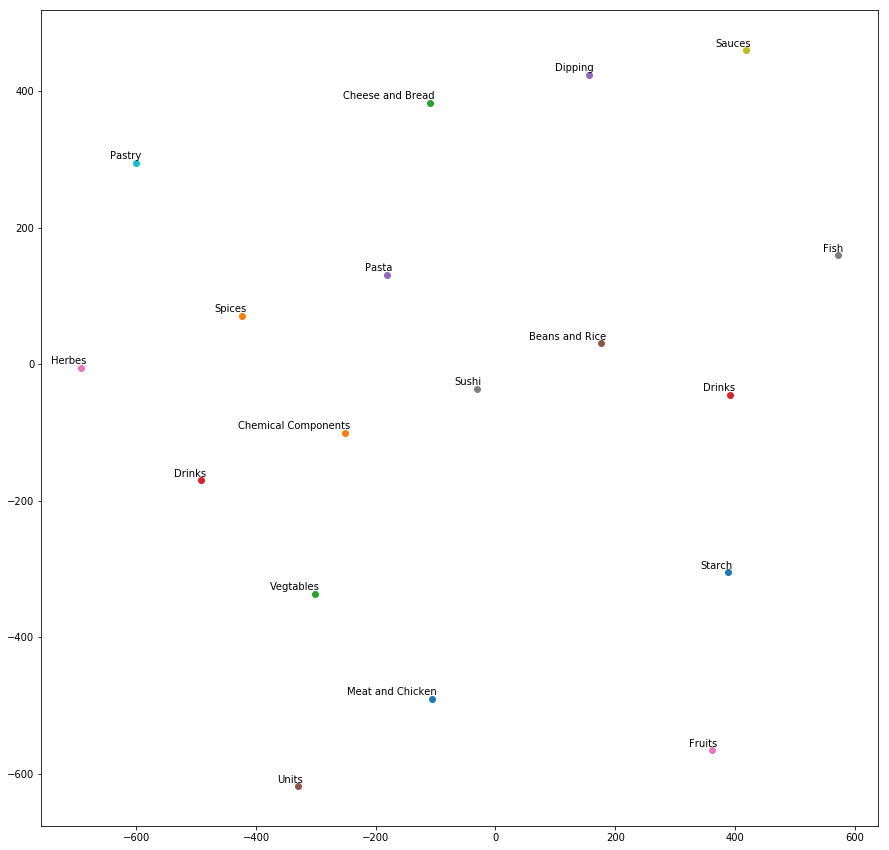

In [131]:
plot_centroids(kmeans_algorithm.cluster_centers_,cluster_labeling)

In [132]:
# change the labels into cluster names
all_recipe_vectors_df['Type'] = all_recipe_vectors_df['labels'].apply(lambda x : cluster_labeling[x]) 

In [133]:
# construct a list having for each ingredient the corresponding cluster
all_recipe_ingred2type = all_recipe_vectors_df[['ingreds','Type']].values.tolist()

In [134]:
# change the previous list into a dictionary mapping each ingredient to cluster
# prev : [ingred,cluster_label] => 
all_recipe_ingred2type_dict = {}
for i in range(0,len(all_recipe_ingred2type)):
    all_recipe_ingred2type_dict[all_recipe_ingred2type[i][0]] = all_recipe_ingred2type[i][1]

In [135]:
recipe_to_components = {}
for i in range(0,len(all_recipe_cleaned_ingreds)): # iterate over claned ingredient list
    
    # create a dictionary having for each cluster name a mapping to zero
    #used for uniformity of dataset
    components = {} 
    for food_type in cluster_labeling.values():
        components[food_type] = 0
    components['Other'] = 0
    
    
    for j in range(0,len(all_recipe_cleaned_ingreds[i])):
        # iterate over tokens
        for k in range(0,len(all_recipe_cleaned_ingreds[i][j])):
            
            ingred = all_recipe_cleaned_ingreds[i][j][k] # single ingredient
            if ingred in all_recipe_ingred2type_dict: # look it up in the dictionary
                # when found increment its count for that recipe
                food_type_of_ingred = all_recipe_ingred2type_dict[ingred] 
                components[food_type_of_ingred] +=1
            else:
                components['Other']+=1
    
    recipe_to_components[i] = components

In [137]:
all_recipe_final_result = all_recipe_unique_recipes.reset_index()

In [139]:
all_recipe_final_result = pd.concat([all_recipe_final_result,pd.DataFrame.from_dict(recipe_to_components).T],axis=1)
#all_recipe_final_result = all_recipe_final_result.drop('ingredients',axis=1)

In [140]:
all_recipe_final_result.head()

,name,ingredients,Beans and Rice,Cheese and Bread,Chemical Components,Dipping,Drinks,Fish,Fruits,Herbes,...,Meat and Chicken,Other,Pasta,Pastry,Sauces,Spices,Starch,Sushi,Units,Vegtables
0,#1 Pumpkin Spice Cookies,"[[[cup, flour], [cup, oat], [teaspoon, powder]...",1,0,3,0,0,0,4,0,...,0,0,0,6,0,5,0,0,0,0
1,'Chinese Buffet' Green Beans,"[[[tablespoon, oil, peanut, sesame], [clove], ...",1,0,2,0,0,0,0,0,...,0,0,0,1,2,2,0,0,0,0
2,'Day Before Payday' Kielbasa and Corn Hash,"[[[tablespoon, oil], [potato], [pound, sausage...",1,0,1,0,0,0,0,0,...,0,0,0,1,1,5,0,0,0,1
3,100-Calorie Pumpkin Pie Tartlets,"[[[foil, baking, cup], [cooking, spray], [cup,...",0,0,1,0,0,0,1,0,...,0,0,0,3,0,3,1,0,0,0
4,2 Minute Cheese Quesadillas,"[[[flour, tortilla], [cup, cheddar, cheese]]]",0,2,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [141]:
all_recipe_df = pd.merge(all_recipe_df,all_recipe_final_result, on='name')

In [142]:
all_recipe_df.head()

,calories,cholesterol,cook_time,dietaryfiber,fat,ingredients_x,name,prep_time,protein,rating,...,Meat and Chicken,Other,Pasta,Pastry,Sauces,Spices,Starch,Sushi,Units,Vegtables
0,298,0.076,45,1,22,"[1 (16 ounce) jar sauerkraut, drained, 1 (8 ou...",Slow Cooker Reuben Dip,4,17,4,...,1,0,0,1,1,0,0,0,1,0
1,298,0.076,45,1,22,"[1 (16 ounce) jar sauerkraut, drained, 1 (8 ou...",Slow Cooker Reuben Dip,4,17,4,...,1,0,0,1,1,0,0,0,1,0
2,298,0.076,45,1,22,"[1 (16 ounce) jar sauerkraut, drained, 1 (8 ou...",Slow Cooker Reuben Dip,4,17,4,...,1,0,0,1,1,0,0,0,1,0
3,298,0.076,45,1,22,"[1 (16 ounce) jar sauerkraut, drained, 1 (8 ou...",Slow Cooker Reuben Dip,4,17,4,...,1,0,0,1,1,0,0,0,1,0
4,298,0.076,45,1,22,"[1 (16 ounce) jar sauerkraut, drained, 1 (8 ou...",Slow Cooker Reuben Dip,4,17,4,...,1,0,0,1,1,0,0,0,1,0


# 3) Cleaning Food.com

First step is to explore what data we have

In [143]:
food_com_df.dtypes

calories                      float64
carbohydrateContent           float64
category                       object
cholesterolContent            float64
cookTime                       object
date                   datetime64[ns]
fatContent                    float64
fiberContent                  float64
ingredients                    object
name                           object
prepTime                       object
proteinContent                float64
review                         object
review_date                    object
saturatedFatContent           float64
servings                       object
sodiumContent                 float64
sugarContent                  float64
dtype: object

In [144]:
print("Number of recipes extracted = {}".format(food_com_df['name'].unique().shape[0]))

Number of recipes extracted = 7184


## 3.a) Cleaning Nutrition related info

In this case all nutrition related information is in numeric format and thus there is no need for parsing as no scale is found.

## 3.b) Cleaning time based data

Moving to the next step would be cleaning data related to time and dates. The only additional column in comparison with the previous dataframe is that in this dataset we have the date in which the user gave a review.

In [145]:
cook_scale = food_com_df['cookTime'].str.replace('\d+','').unique()
prep_scale = food_com_df['prepTime'].str.replace('\d+','').unique()
cook_scale,prep_scale

(array([u' mins', u' hrs ', u' hrs  mins'], dtype=object),
 array([u' mins', u' hrs  mins', u' hrs '], dtype=object))

In [146]:
def rescale_time(input_time,time_scale=['hrs','mins']):
    
    input_time = input_time.strip()
    total_time = 0
    for i in range(0,len(time_scale)):
        res = input_time.split(time_scale[i])
        if res[0] == input_time:
            continue
        else:
            input_time = input_time[1]
            if time_scale[i] == 'hrs':
                cnst = 60
            elif time_scale[i] == 'mins':
                cnst = 1
            total_time += (int(res[0]) * cnst)
            
    return total_time
        

In [147]:
food_com_df['prepTime'] = food_com_df['prepTime'].apply(lambda x : rescale_time(x)).astype(int)
food_com_df['cookTime'] = food_com_df['cookTime'].apply(lambda x : rescale_time(x)).astype(int)

Moving on to date data we do as we did in the first step : extract month,day and year and construct columns out of them.

In [148]:
food_month_map = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,
                  'October':10,'November':11,'December':12}

In [149]:
def extract_month_food(time,month_mapping):
    extract_month = time.split(' ')[0]
    return month_mapping[extract_month]

In [150]:
def extract_day_food(time):
    return int(time.split(' ')[1].replace(',',''))

In [151]:
def extract_year_food(time):
    return int(time.split(',')[1])

In [152]:
food_com_df['review_day']   = food_com_df['review_date'].apply(lambda x: extract_day_food(x))
food_com_df['review_month'] = food_com_df['review_date'].apply(lambda x: extract_month_food(x,food_month_map))
food_com_df['review_year']  = food_com_df['review_date'].apply(lambda x: extract_year_food(x))

In [153]:
food_com_df['post_day'] = food_com_df['date'].map(lambda x: x.day)
food_com_df['post_month'] = food_com_df['date'].map(lambda x: x.month)
food_com_df['post_year'] = food_com_df['date'].map(lambda x: x.year)

## 3.c) Fix servings information

In [154]:
def parse_floats(input_serving):
    
    if '/' in input_serving: # if data contains a fraction
        res = input_serving.split('/')
        temp = res[0].split(' ')
        if len(temp)>1:
            return float(temp[0]) + (float(temp[1])/float(res[1]))
        else:
            return float(temp[0])/float(res[1])
        
    else:
        return float(input_serving)

In [155]:
food_com_df['servings'] = food_com_df['servings'].apply(lambda x : parse_floats(x))

In [156]:
food_com_df.head()

,calories,carbohydrateContent,category,cholesterolContent,cookTime,date,fatContent,fiberContent,ingredients,name,...,saturatedFatContent,servings,sodiumContent,sugarContent,review_day,review_month,review_year,post_day,post_month,post_year
0,499.9,56.0,"[Soups & stews, Chicken breasts, Chicken]",63.5,15,2005-11-05,19.6,2.6,"[boneless chicken breast half, potatoes, carro...",Yellow Curry Chicken (Thai Soup),...,12.6,6.0,477.1,41.4,6,12,2010,5,11,2005
1,499.9,56.0,"[Soups & stews, Chicken breasts, Chicken]",63.5,15,2005-11-05,19.6,2.6,"[boneless chicken breast half, potatoes, carro...",Yellow Curry Chicken (Thai Soup),...,12.6,6.0,477.1,41.4,1,6,2008,5,11,2005
10,354.0,55.3,"[Coffee cakes, Yeast breads, Breads]",54.5,15,2004-05-10,12.7,0.9,"[butter, sour cream, sugar, salt, active dry y...",King Cake,...,7.1,2.0,194.3,32.7,20,2,2010,10,5,2004
100,179.2,36.5,"[Flat Shaped breads, Breads, Asian]",0.0,60,2007-10-09,1.0,2.2,"[all-purpose flour, whole wheat flour, salt, b...",Best Healthy Vegan Indian Naan (Or Garlic Naan...,...,0.1,12.0,235.8,0.9,19,12,2009,9,10,2007
1000,93.0,18.1,"[Salads, Side dishes, Black beans]",0.0,0,2004-05-06,2.1,2.7,"[frozen corn, black beans, olive oil, red bell...",Mexican Corn & Black Bean Salad,...,0.3,9.0,132.2,0.1,2,2,2009,6,5,2004


## 3.d) Clean ingredient based information

In this set we repeat the same analysis done on the previous dataset

In [157]:
# create a series having for each recipe the corresponding ingredients
# we note that each row in our dataset having a review for this recipe
foodcom_unique_recipes = food_com_df.groupby('name')['ingredients'].apply(list)

In [158]:
for i in range(0,len(foodcom_unique_recipes)):
    foodcom_unique_recipes[i] = foodcom_unique_recipes[i][0]

In [159]:
foodcom_unique_recipes[0]

[u'soy sauce',
 u'Worcestershire sauce',
 u'olive oil',
 u'garlic cloves',
 u'rosemary',
 u'fresh ground black pepper',
 u'london broil beef']

In [160]:
# a list storing the cleaned ingredient list
foodcom_cleaned_ingreds = cleaning_ingredients(foodcom_unique_recipes)

In [161]:
# apply cleaning also on series having unique recipes
foodcom_unique_recipes = foodcom_unique_recipes.apply(lambda x: cleaning_ingredients([x]) )

In [162]:
foodcom_flattened = get_ingredients(foodcom_cleaned_ingreds) # flatten the list

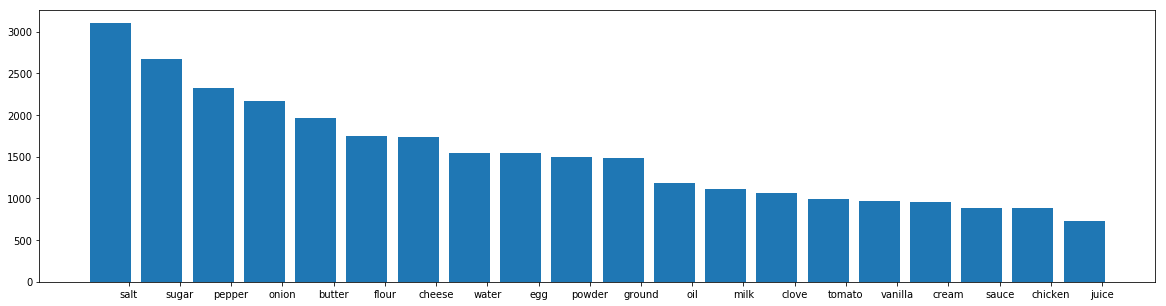

In [163]:
plot_frequency(foodcom_flattened)

In [164]:
foodcom_x,foodcom_y,foodcom_vectors,foodcom_labels = get_tsne_projections(word2vec_model,np.unique(foodcom_flattened))

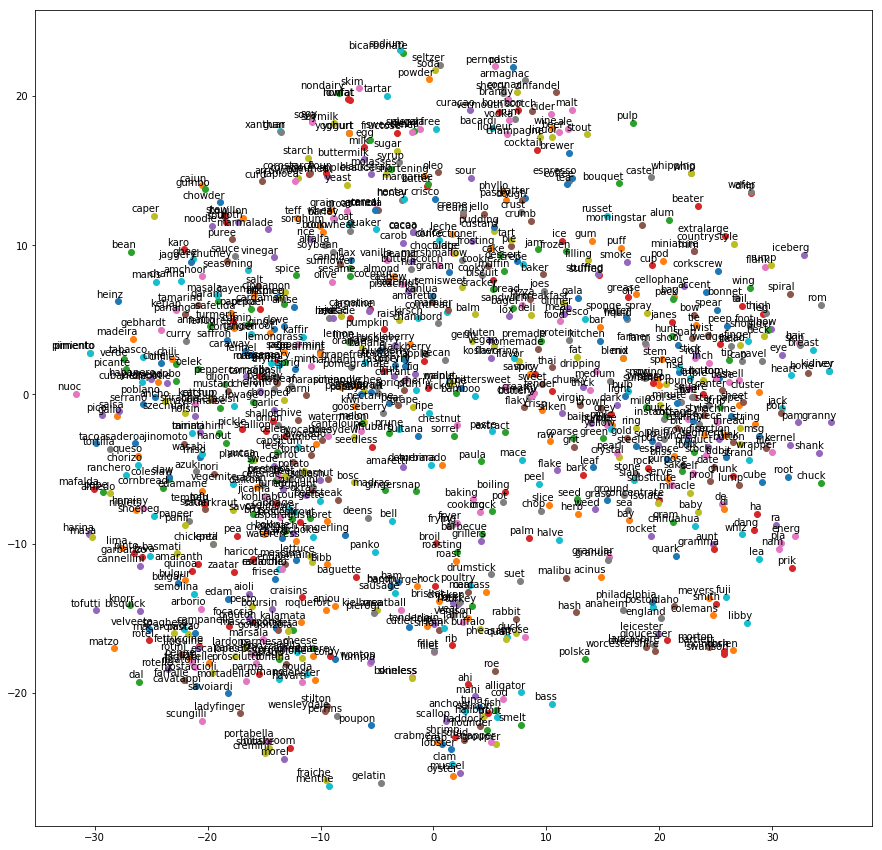

In [165]:
tsne_plot(foodcom_x,foodcom_y,foodcom_labels)

As observed from the plot above, it is really hard to detect any clusters, we will use kmeans to cluster these embeddings. The same as the previous case

In [166]:
# construct a matrix having the embeddings and a column having a rating
foodcom_vectors,foodcom_labels = np.asarray(foodcom_vectors),np.asarray(foodcom_labels)
foodcom_labels = foodcom_labels.reshape(-1,1)
temp = np.hstack((foodcom_vectors,foodcom_labels))
foodcom_vectors_df = pd.DataFrame(temp)

In [167]:
foodcom_vectors_df = foodcom_vectors_df.rename(columns={300:'ingreds'})

In [168]:
foodcom_vectors_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,ingreds
0,0.057523,0.022912,0.074641,-0.001355,0.24066,-0.130644,0.083622,0.015531,-0.072384,0.11804,...,0.10053,-0.039356,-0.033321,-0.039255,-0.011253,0.061093,-0.06423,-0.055645,0.051107,accent
1,0.243377,0.297705,0.113111,0.12885,-0.253405,-0.212215,-0.081373,-0.306011,-0.050842,-0.101237,...,0.18257,-0.036555,-0.097559,-0.150042,0.163546,0.075541,0.076129,-0.025974,-0.031822,acinus
2,0.037905,-0.095917,-0.104802,0.009615,0.072668,-0.230151,0.069384,0.020203,0.028175,-0.180208,...,-0.159758,0.015869,-0.013746,-0.027939,0.281874,0.102379,0.0615,-0.077196,-0.022463,adobo
3,0.033443,0.051869,0.118463,0.054114,-0.060714,-0.232838,-0.034893,0.005562,0.165613,-0.036502,...,0.091539,0.03119,-0.111768,0.098885,0.030854,-0.049104,-0.079241,-0.054921,0.134822,ahi
4,0.061899,-0.065178,-0.106991,-0.057812,-0.070915,-0.140542,-0.087897,-0.092886,0.140184,-0.046494,...,-0.010614,-0.125431,0.059821,0.011947,0.067145,-0.060935,-0.019185,-0.018793,0.055386,aioli


In [169]:
temp_benchmark = foodcom_vectors_df.loc[:, ~foodcom_vectors_df.columns.isin(['ingreds'])]
sil_vs_k = kmeans_plus(temp_benchmark)

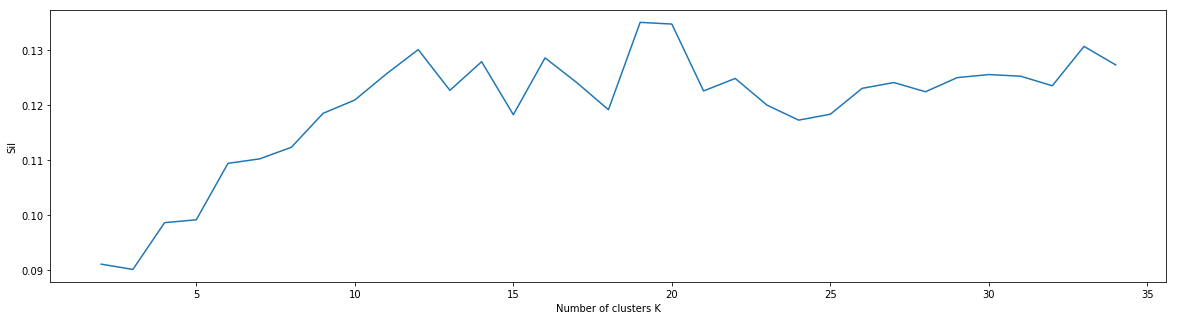

In [170]:
plt.xlabel('Number of clusters K')
plt.ylabel('Sil')
plt.plot(sil_vs_k.keys(),sil_vs_k.values())

We can see that a k of 19 achieves best performance

In [171]:
kmeans_algorithm = KMeans(n_clusters=19,random_state=0).fit(temp_benchmark.values) # fit the kmeans algorithm

In [172]:
foodcom_vectors_df['labels'] = kmeans_algorithm.labels_

In [176]:
# display five samples  per cluster id
sampled_data = []
for i in range(0,19):
    subset = foodcom_vectors_df[foodcom_vectors_df['labels'] == i]
    subset = subset.sample(5)
    sampled_data.append(subset)
sampled_data = pd.concat(sampled_data)

In [177]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(sampled_data[['ingreds','labels']])

,ingreds,labels
302,flounder,0
579,pheasant,0
179,clam,0
628,quail,0
450,lobster,0
346,granular,1
396,inch,1
672,sake,1
49,bamboo,1
751,spring,1


In [178]:
foodcom_cluster_labeling = {0:'Fish',
                            1:'Irrelevant',
                            2:'Cheese and Bread',
                            3:'Beans and Rice',
                            4:'Spices',
                            5:'Meat and Chicken',
                            6:'Vegtables',
                            7:'Pastry',
                            8:'Dipping',
                            9: 'Fruits',
                            10:'Irrelevant',
                            11:'Fruits',
                            12:'Pastry',
                            13:'Irrelevant',
                            14:'Irrelevant',
                            15:'Sauces',
                            16:'Drinks',
                            17:'Pasta',
                            18:'Cheese and Bread',
                           }

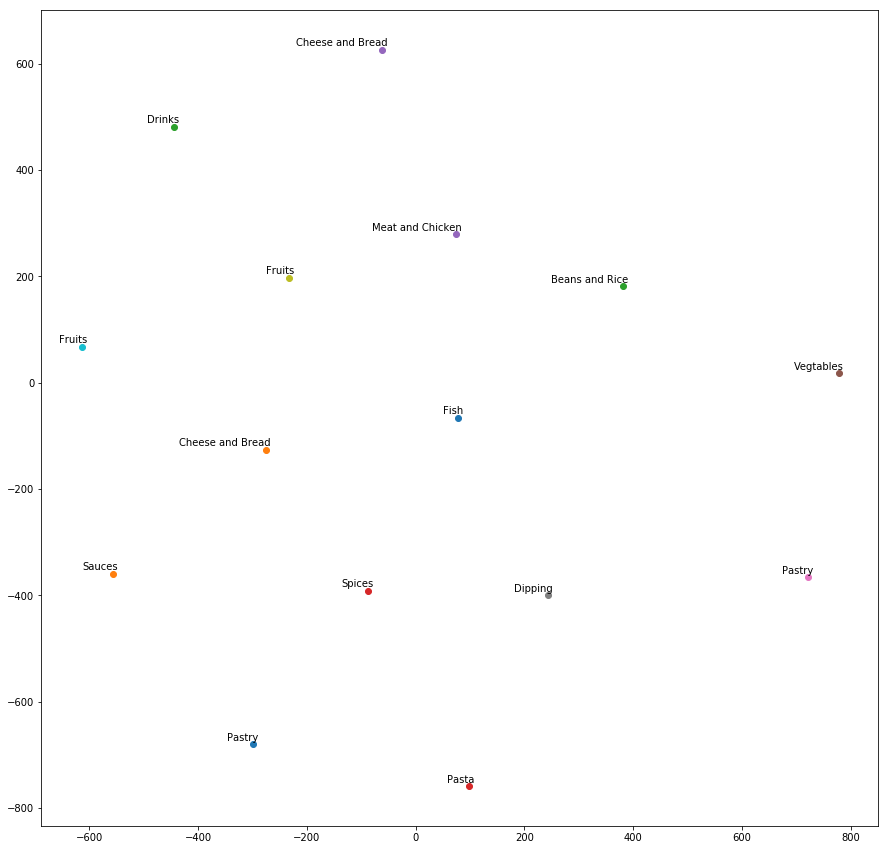

In [179]:
plot_centroids(kmeans_algorithm.cluster_centers_,foodcom_cluster_labeling)

In [180]:
# change cluster label to corresponding cluster
foodcom_vectors_df['Type'] = foodcom_vectors_df['labels'].apply(lambda x : foodcom_cluster_labeling[x])

In [181]:
# create a list having the mapping of each ingredient and cluster label
foodcom_ingred2type = foodcom_vectors_df[['ingreds','Type']].values.tolist()

In [182]:
# convert the previous list into dictionary
foodcom_ingred2type_dict = {}
for i in range(0,len(foodcom_ingred2type)):
    foodcom_ingred2type_dict[foodcom_ingred2type[i][0]] = foodcom_ingred2type[i][1]

In [183]:
recipe_to_components = {}
for i in range(0,len(foodcom_cleaned_ingreds)): # iterate over all recieps
    
    # create for each cluster label a mapping to zero , for uniformity of data
    components = {}
    for food_type in foodcom_cluster_labeling.values():
        components[food_type] = 0
    components['Other'] = 0
    
    # iterate over all ingredients
    for j in range(0,len(foodcom_cleaned_ingreds[i])): 
        for k in range(0,len(foodcom_cleaned_ingreds[i][j])):
            ingred = foodcom_cleaned_ingreds[i][j][k] # get ingredient
            if ingred in foodcom_ingred2type_dict:
                food_type_of_ingred = foodcom_ingred2type_dict[ingred] # find mapping
                components[food_type_of_ingred] +=1  # increase count
            else:
                components['Other']+=1
    
    recipe_to_components[i] = components

In [184]:
foodcom_final_result = foodcom_unique_recipes.reset_index()

In [185]:
foodcom_final_result = pd.concat([foodcom_final_result,pd.DataFrame.from_dict(recipe_to_components).T],axis=1)

In [186]:
foodcom_final_result.head()

,name,ingredients,Beans and Rice,Cheese and Bread,Dipping,Drinks,Fish,Fruits,Irrelevant,Meat and Chicken,Other,Pasta,Pastry,Sauces,Spices,Vegtables
0,""" Ant"" Kelly's London Broil Marinade","[[[soy, sauce], [worcestershire, sauce], [oil]...",0,0,0,0,0,0,2,2,0,0,1,3,3,0
1,""" Creamy "" Vegan Potato-Leek Soup","[[[oil], [leek], [clove], [russet, potato], [b...",0,0,0,0,0,0,1,1,0,0,0,0,2,4
2,""" Da Best"" Chicago-Style Italian Beef","[[[rump, roast], [powder], [oregano], [pepper]]]",0,0,0,0,0,0,0,2,0,0,1,0,2,0
3,""" Healthy"" Pumpkin Pie","[[[pumpkin], [skim, milk], [lowfat, soymilk], ...",0,0,0,0,0,2,4,0,0,0,7,0,1,0
4,""" Jamba Juice at Home"" Strawberries Wild Smoo...","[[[strawberry], [banana]]]",0,0,0,0,0,2,0,0,0,0,0,0,0,0


In [187]:
food_com_df = pd.merge(food_com_df,foodcom_final_result, on='name')

In [188]:
food_com_df.head()

,calories,carbohydrateContent,category,cholesterolContent,cookTime,date,fatContent,fiberContent,ingredients_x,name,...,Fish,Fruits,Irrelevant,Meat and Chicken,Other,Pasta,Pastry,Sauces,Spices,Vegtables
0,499.9,56.0,"[Soups & stews, Chicken breasts, Chicken]",63.5,15,2005-11-05,19.6,2.6,"[boneless chicken breast half, potatoes, carro...",Yellow Curry Chicken (Thai Soup),...,0,0,6,3,0,0,5,1,0,2
1,499.9,56.0,"[Soups & stews, Chicken breasts, Chicken]",63.5,15,2005-11-05,19.6,2.6,"[boneless chicken breast half, potatoes, carro...",Yellow Curry Chicken (Thai Soup),...,0,0,6,3,0,0,5,1,0,2
2,499.9,56.0,"[Soups & stews, Chicken breasts, Chicken]",63.5,15,2005-11-05,19.6,2.6,"[boneless chicken breast half, potatoes, carro...",Yellow Curry Chicken (Thai Soup),...,0,0,6,3,0,0,5,1,0,2
3,354.0,55.3,"[Coffee cakes, Yeast breads, Breads]",54.5,15,2004-05-10,12.7,0.9,"[butter, sour cream, sugar, salt, active dry y...",King Cake,...,0,0,1,0,0,0,8,0,0,0
4,354.0,55.3,"[Coffee cakes, Yeast breads, Breads]",54.5,15,2004-05-10,12.7,0.9,"[butter, sour cream, sugar, salt, active dry y...",King Cake,...,0,0,1,0,0,0,8,0,0,0


## Working with the reviews

We will train a multiclass classifier to augment the food.com dataset with ratings.

In [189]:
stop = stopwords.words('english')
lem = WordNetLemmatizer()

In [190]:
def remove_noncharacters(input_):
    return re.sub('[^a-zA-Z]','',input_) # remove all non-alphabetic characters

In [191]:
def tokenize(input_):
    return input_.split() # tokenize all words by splitting by space (string => list)

In [192]:
def remove_stop_words(stop_words,input_):
    return list(filter(lambda x : x not in stop_words,input_)) # remove stopwords

In [193]:
def word_lemmatization(tokens,lemmatizer):
    return list(filter(lambda x : lemmatizer.lemmatize(x),tokens))

Apply the text cleaning over the reviews again. 
1. tokenization
2. removing non-alphabets
3. remove stop words
4. lemmatize words

In [194]:
all_recipe_df['review'] = all_recipe_df['review'].apply(lambda x : tokenize(x))
food_com_df['review'] = food_com_df['review'].apply(lambda x : tokenize(x))

In [195]:
all_recipe_df['review'] = all_recipe_df['review'].apply(lambda x : list(map(lambda y : remove_noncharacters(y),x)))
food_com_df['review'] = food_com_df['review'].apply(lambda x : list(map(lambda y : remove_noncharacters(y),x)))

In [196]:
all_recipe_df['review'] = all_recipe_df['review'].apply(lambda x : list(filter(lambda y : y!='',x)))
food_com_df['review'] = food_com_df['review'].apply(lambda x : list(filter(lambda y : y!='',x)))

In [197]:
all_recipe_df['review'] = all_recipe_df['review'].apply(lambda x : remove_stop_words(stop,x))
food_com_df['review'] = food_com_df['review'].apply(lambda x : remove_stop_words(stop,x))

In [198]:
all_recipe_df['review'] = all_recipe_df['review'].apply(lambda x : word_lemmatization(x,lem))
food_com_df['review'] = food_com_df['review'].apply(lambda x : word_lemmatization(x,lem))

In [199]:
def build_embeddings(reviews):
    
    """
        for each word we build the embedding of a review.
        for each word in the review we apply word2vvec for that word
        Then we average all embeddings resulting as the embedding of the review
    
    """
    
    
    review_embeddings = []
    dimension = 300
    
    for i in range(0,reviews.shape[0]):
        
        tokens = reviews[i]
        num_tokens = len(tokens)
        if num_tokens == 0:
            num_tokens+=1
        average_embed = [0 for i in range(0,dimension)]
        for token in tokens:
            try:
                embedding = word2vec_model[token]
            except:
                embedding = [0 for i in range(0,dimension)]
            average_embed = [sum(x) for x in zip(average_embed,embedding)]
        average_embed = [x/num_tokens for x in average_embed]
        review_embeddings.append(average_embed)
    
    return review_embeddings    

In [200]:
# construct all recipe embeddings for each review in the dataset
all_recipe_embeddings = build_embeddings(all_recipe_df['review'].values) 

In [201]:
all_recipe_embeddings = np.asarray(all_recipe_embeddings)

In [202]:
all_recipe_ratings = all_recipe_df['rating'].values

In [203]:
# construct food.com embeddings for each review in the dataset
food_com_embeddings = np.asarray(build_embeddings(food_com_df['review'].values))

### handling imbalance

We know that the all_recipe.com dataset have labels and the food.com doesn't. <br>
We train a model on the reviews of all_recipe.com and use the trained model to predict food.com labels.

In [204]:
from imblearn.over_sampling import RandomOverSampler

In [205]:
# over sample the dataset due to the unbalance , this dataset should contain a dataset which is balanced
# this is needed to train a model 
ros = RandomOverSampler(random_state=0) 
X_resampled, y_resampled = ros.fit_resample(all_recipe_embeddings, all_recipe_ratings)

In [206]:
X_resampled.shape,y_resampled.shape

((723230, 300), (723230,))

In [207]:
combine = np.hstack((X_resampled,y_resampled.reshape(-1,1)))

In [208]:
np.random.shuffle(combine)

In [209]:
X_shuffled,y_shuffled = combine[:,0:300],combine[:,-1]

In [210]:
from sklearn import metrics
#clf = LinearSVC(random_state=0, tol=1e-4,multi_class='crammer_singer')
clf = LogisticRegression(random_state=0,multi_class='multinomial',solver ='lbfgs')
scores = cross_val_score(clf,X_shuffled,y_shuffled, cv=10)

/home/omar/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/omar/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/omar/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/omar/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/omar/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.


In [211]:
print("Logistic model Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Logistic model Accuracy: 0.61 (+/- 0.01)


In [212]:
#from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegression(random_state=0,multi_class='multinomial',solver = 'lbfgs').fit(X_shuffled,y_shuffled)

/home/omar/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [213]:
predicted_labels = clf.predict(food_com_embeddings)

In [214]:
food_com_df['rating'] = predicted_labels

## Cleaning food_net.com 

In [215]:
food_net_df.head() # get glimpse of data

,category,cook_time,difficulty,name,prep_time,rating,review,review_date
0,"[Pizza, European, Italian, Baking, Fall, Sprin...",30,Intermediate,Basic Pizza Dough - By Hand Method,5,4,"Followed recipe and instructions, Dough was 's...","December 06, 2011"
1,[],30,Intermediate,Basic Pizza Dough - By Hand Method,5,4,If your a person who likes those thick crust p...,"November 22, 2009"
10,[],5,Easy,Neely's Peach Iced Tea,5,5,Corrine! You can't rate something you haven't...,"August 06, 2010"
100,[],1,Easy,Zucchini Bread,20,4,This recipe is very good. I did have to subst...,"July 08, 2012"
1000,[],15,Easy,Cheesy Potatoes,5,4,I't is very Cheesey and it has a perfect taste.,"March 22, 2008"


In [216]:
print("Recipies extracted from food_net.com = {}".format(food_net_df['name'].unique().shape[0]))

Recipies extracted from food_net.com = 1827


In [217]:
food_net_df.dtypes

category       object
cook_time       int64
difficulty     object
name           object
prep_time       int64
rating          int64
review         object
review_date    object
dtype: object

The first thing to do is to convert time related columns into integers as there is no scale as observed in the first dataframe.

In [218]:
food_net_df['cook_time'] = food_net_df['cook_time'].astype(int)

In [219]:
food_net_df['prep_time'] = food_net_df['prep_time'].astype(int)

Next step is to change the difficulty level into a dummy encoding as it makes it easier to use in the analyis.

In [220]:
diff_dummy = pd.get_dummies(food_net_df['difficulty'])
food_net_df = food_net_df.drop('difficulty',axis = 1)
food_net_df = pd.concat((food_net_df,diff_dummy),axis=1)

In [221]:
food_net_df.head()

,category,cook_time,name,prep_time,rating,review,review_date,--,Difficult,Easy,Intermediate
0,"[Pizza, European, Italian, Baking, Fall, Sprin...",30,Basic Pizza Dough - By Hand Method,5,4,"Followed recipe and instructions, Dough was 's...","December 06, 2011",0,0,0,1
1,[],30,Basic Pizza Dough - By Hand Method,5,4,If your a person who likes those thick crust p...,"November 22, 2009",0,0,0,1
10,[],5,Neely's Peach Iced Tea,5,5,Corrine! You can't rate something you haven't...,"August 06, 2010",0,0,1,0
100,[],1,Zucchini Bread,20,4,This recipe is very good. I did have to subst...,"July 08, 2012",0,0,1,0
1000,[],15,Cheesy Potatoes,5,4,I't is very Cheesey and it has a perfect taste.,"March 22, 2008",0,0,1,0


# Merging the datasets

As we can observe from the above schemas the first two datasets share a common skeleton and thus we will combine them and discard the last dataset from our analysis

In [222]:
food_com_df = food_com_df.rename(columns = {'cholesterolContent':'cholesterol',
                                            'fatContent':'fat',
                                            'proteinContent':'protein',
                                            'fiberContent':'fiber',
                                            'carbohydrateContent':'totalcarbs',
                                            'sodiumContent':'sodium',
                                            'cookTime':'cook_time',
                                            'prepTime':'prep_time',
                                            'post_day':'day',
                                            'post_month':'month',
                                            'post_year':'year',
                                           })

In [223]:
food_com_df = food_com_df.drop(['Other','category','date','review_date','review_day','review_month','review_year','saturatedFatContent','sugarContent'],axis = 1)

In [224]:
food_com_df['Herbes'],food_com_df['Starch'],food_com_df['Sushi'],food_com_df['Chemical Components']= 0,0,0,0

In [225]:
all_recipe_df = all_recipe_df.rename(columns = {'dietaryfiber':'fiber'})

In [226]:
all_recipe_df = all_recipe_df.drop(['Other','Units','total_time']  ,axis=1)

In [227]:
all_recipe_df.shape,food_com_df.shape

((159309, 35), (24253, 35))

In [228]:
test = pd.concat([all_recipe_df,food_com_df], ignore_index=True)

/home/omar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [231]:
test.to_json(data_directory + '/unified_data.json')